In [265]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from itertools import combinations
from collections import deque

In [266]:
class NaiveNetwork(object):
    def __init__(self, num_nodes):
        self.adj = {i: set() for i in range(num_nodes)}
        self.num_nodes = num_nodes

    def add_edge(self, i, j):
        self.adj[i].add(j)
        self.adj[j].add(i)

    def neighbors(self, i):
        return self.adj[i]

    def edge_list(self):
        return [(i, j) for i in self.adj for j in self.adj[i] if i < j]
    
class NaiveRandomGeometricGraph(NaiveNetwork):
    def __init__(self, num_nodes, k_avg):
        super().__init__(num_nodes)
        self.k_avg = k_avg

        self.radius = np.sqrt(self.k_avg / (np.pi * self.num_nodes))
        self.positions = np.random.rand(num_nodes, 2)
        self.construct_edges()

    def construct_edges(self):
        for i in range(self.num_nodes):
            for j in range(i + 1, self.num_nodes):
                if np.linalg.norm(self.positions[i] - self.positions[j]) < self.radius:
                    self.add_edge(i, j)

In [267]:
num_nodes = 10000
k_avg = 20

nodes_positions = np.random.rand(num_nodes, 2)
radius = np.sqrt(k_avg / (np.pi * num_nodes))

rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})

Implementation of concentrated vs dispersed infection

In [268]:
class Infectious_Network():
    def __init__(self, network: nx.Graph, infection_probi: float, recovery_probi: float, initial_infection: float, 
                 concentrated: bool):
        self.network = network
        self.initial_infection = initial_infection
        self.concentrated = concentrated

        self.num_nodes = network.number_of_nodes()
        self.positions = nx.get_node_attributes(network, "pos")

        self.state = np.zeros(self.num_nodes) # S = 0, I = 1, R = 2
        self.infection_probi = infection_probi
        self.recovery_probi = recovery_probi 

        if concentrated:
            self.concentrated_infection()
        else:
            self.disperse_infection()

    def disperse_infection(self): # randomly choose nodes to infect
        initial_infected_nodes = np.random.choice(self.num_nodes, 
                                                  int(self.initial_infection*self.num_nodes), replace=False)
        for i in initial_infected_nodes:
            self.state[i] = 1  

    def concentrated_infection(self): # choose nodes closest to the outbreak location
        outbreak_location = np.random.rand(1, 2)
        nodes_positions = np.array(list(self.positions.values()))
        nodes_distances_from_outbreak = np.linalg.norm(nodes_positions - outbreak_location, axis=1)
        nodes_sorted_by_distance = np.argsort(nodes_distances_from_outbreak)
        initial_infected_nodes = nodes_sorted_by_distance[:int(self.initial_infection*self.num_nodes)]
        
        for i in initial_infected_nodes:
            self.state[i] = 1     

    def increment_time(self):
        new_state = self.state.copy()
        for i in range(self.num_nodes):
            if self.state[i] == 1: # I = 1
                # check if node i's neighours could be infected
                for j in self.network.neighbors(i):
                    if self.state[j] == 0 and np.random.rand() < self.infection_probi: # S = 0
                        new_state[j] = 1
                # check if node i could recover
                if np.random.rand() < self.recovery_probi:
                    new_state[i] = 2
        self.state = new_state


    def increment_till_extinction(self):
        S, I, R = [], [], []
        while len([i for i in self.state if i == 1]):
            S.append(len([i for i in self.state if i == 0]))
            I.append(len([i for i in self.state if i == 1]))
            R.append(len([i for i in self.state if i == 2]))

            self.increment_time()
        return S, I, R

In [269]:
def shortest_path_length(infectious_network: Infectious_Network, source, target):  
    if source == target:
        return 0
    queue = deque([(source, 0)])
    while queue:
        node, distance = queue.popleft()
        if node == target:
            return distance
        for neighbor in infectious_network.network.neighbors(node):
            new_distance = distance + 1
            if neighbor == target:
                return new_distance
            queue.append((neighbor, new_distance))

In [270]:
def find_basic_reproduction_number(infection_probi, recovery_probi):
    return infection_probi * k_avg / recovery_probi

In [287]:
initial_infection = 0.001
infection_probability = 0.3
infection_probability_small = 0.01
recovery_probability = 0.1
sample_size = 50
max_size = 1000

Mean shortest path

In [272]:
def measure_mean_shortest_path(infectious_network: Infectious_Network):
    infected_nodes = [i for i in range(infectious_network.num_nodes) if infectious_network.state[i] == 1]
    shortest_paths = []
    for i, j in combinations(infected_nodes, 2):
        try:
            shortest_path = nx.shortest_path_length(infectious_network.network, source=i, target=j)
            shortest_paths.append(shortest_path)
        except nx.NetworkXNoPath: # if no path exist
            continue  

    return np.mean(shortest_paths)

In [273]:
# disperse network
averaged_mean_shortest_path_d = []
for _ in range(sample_size):
    disperse_rgg = Infectious_Network(rgg, infection_probability, recovery_probability, initial_infection, False)
    averaged_mean_shortest_path_d.append(measure_mean_shortest_path(disperse_rgg))

print(np.mean(averaged_mean_shortest_path_d))

25.72666666666667


In [274]:
# concentrated network
averaged_mean_shortest_path_c = []
for _ in range(sample_size):
    disperse_rgg = Infectious_Network(rgg, infection_probability, recovery_probability, initial_infection, True)
    averaged_mean_shortest_path_c.append(measure_mean_shortest_path(disperse_rgg))

print(np.mean(averaged_mean_shortest_path_c))

1.1840000000000002


SIR process

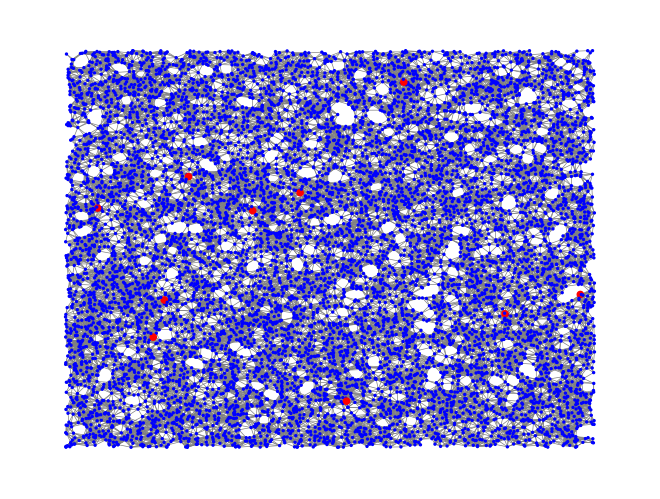

In [275]:
# Single sample
disperse_rgg = Infectious_Network(rgg, infection_probability, recovery_probability, initial_infection, False)
colors = ['blue' if state == 0 else 'red' if state == 1 else 'green' for state in disperse_rgg.state]
size = [20 if state == 1 else 2 for state in disperse_rgg.state]
nx.draw(rgg, pos=disperse_rgg.positions, node_color=colors, width=0.5, 
        edge_color='gray', with_labels=False, node_size=size)

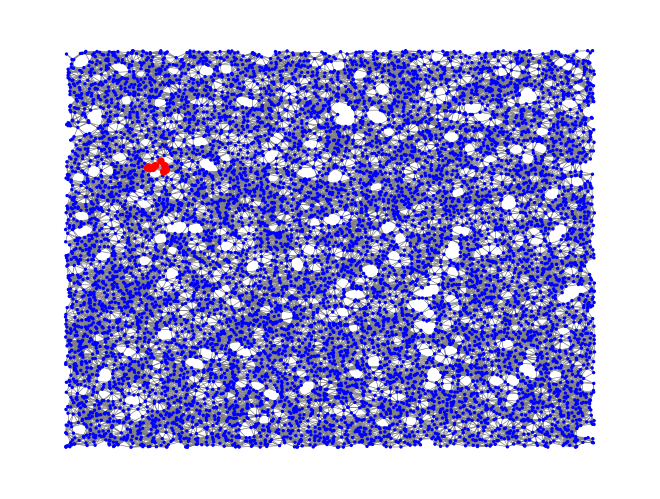

In [276]:
# Single sample
concentrated_rgg = Infectious_Network(rgg, infection_probability, recovery_probability, initial_infection, True)
colors = ['blue' if state == 0 else 'red' if state == 1 else 'green' for state in concentrated_rgg.state]
size = [20 if state == 1 else 2 for state in concentrated_rgg.state]
nx.draw(rgg, pos=concentrated_rgg.positions, node_color=colors, width=0.5, 
        edge_color='gray', with_labels=False, node_size=size)

In [277]:
def append_till_length(lst):
    while len(lst) < max_size:
        lst.append(lst[-1])
    return np.array(lst)

In [278]:
# Averaged sample
Sd, Id, Rd = np.zeros(max_size), np.zeros(max_size), np.zeros(max_size)
avg_idx = 0
for _ in range(sample_size):
    rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})
    disperse_rgg = Infectious_Network(rgg, infection_probability, recovery_probability, initial_infection, False)
    S, I, R = disperse_rgg.increment_till_extinction()
    avg_idx += len(S)
    Sd += append_till_length(S)
    Id += append_till_length(I)
    Rd += append_till_length(R)

Sd /= sample_size
Id /= sample_size
Rd /= sample_size  
avg_idx /= sample_size 
avg_idx = int(avg_idx)

Sd, Id, Rd = Sd[:avg_idx], Id[:avg_idx], Rd[:avg_idx]

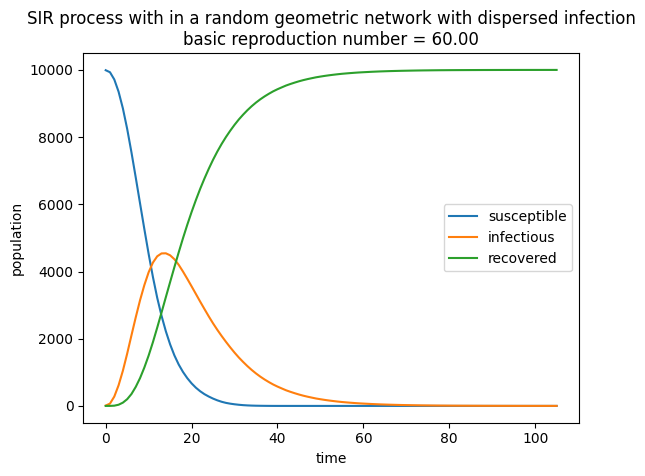

In [279]:
time = np.arange(0, len(Sd), 1)
plt.plot(time, Sd, label="susceptible")
plt.plot(time, Id, label="infectious")
plt.plot(time, Rd, label="recovered")
plt.legend()
plt.title(f"SIR process with in a random geometric network with dispersed infection" +
          f"\nbasic reproduction number = {find_basic_reproduction_number(infection_probability, recovery_probability):.2f}")
plt.xlabel("time")
plt.ylabel("population")
plt.show()


In [ ]:
# Averaged sample
Sd_2, Id_2, Rd_2 = np.zeros(max_size), np.zeros(max_size), np.zeros(max_size)
avg_idx_2 = 0
for _ in range(sample_size):
    rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})
    disperse_rgg = Infectious_Network(rgg, infection_probability_small, recovery_probability, initial_infection, False)
    S, I, R = disperse_rgg.increment_till_extinction()
    avg_idx_2 += len(S)
    Sd_2 += append_till_length(S)
    Id_2 += append_till_length(I)
    Rd_2 += append_till_length(R)

Sd_2 /= sample_size
Id_2 /= sample_size
Rd_2 /= sample_size  
avg_idx_2 /= sample_size 
avg_idx_2 = int(avg_idx_2)

Sd_2, Id_2, Rd_2 = Sd_2[:avg_idx_2], Id_2[:avg_idx_2], Rd_2[:avg_idx_2]

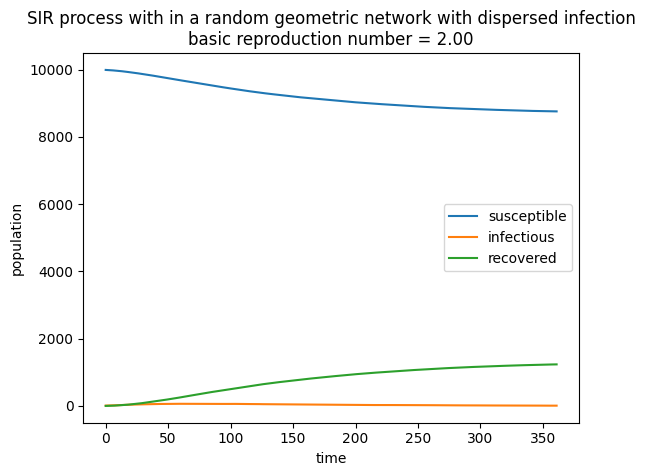

In [289]:
time = np.arange(0, len(Sd_2), 1)
plt.plot(time, Sd_2, label="susceptible")
plt.plot(time, Id_2, label="infectious")
plt.plot(time, Rd_2, label="recovered")
plt.legend()
plt.title(f"SIR process with in a random geometric network with dispersed infection" +
          f"\nbasic reproduction number = {find_basic_reproduction_number(infection_probability_small, recovery_probability):.2f}")
plt.xlabel("time")
plt.ylabel("population")
plt.show()

In [290]:
# Averaged sample
Sc, Ic, Rc = np.zeros(max_size), np.zeros(max_size), np.zeros(max_size)
avg_idx_c = 0
for _ in range(sample_size):
    rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})
    concentrated_rgg = Infectious_Network(rgg, infection_probability, recovery_probability, initial_infection, True)
    S, I, R = concentrated_rgg.increment_till_extinction()
    avg_idx_c += len(S)
    Sc += append_till_length(S)
    Ic += append_till_length(I)
    Rc += append_till_length(R)

Sc /= sample_size
Ic /= sample_size
Rc /= sample_size   
avg_idx_c /= sample_size
avg_idx_c = int(avg_idx_c)

Sc, Ic, Rc = Sc[:avg_idx_c], Ic[:avg_idx_c], Rc[:avg_idx_c]

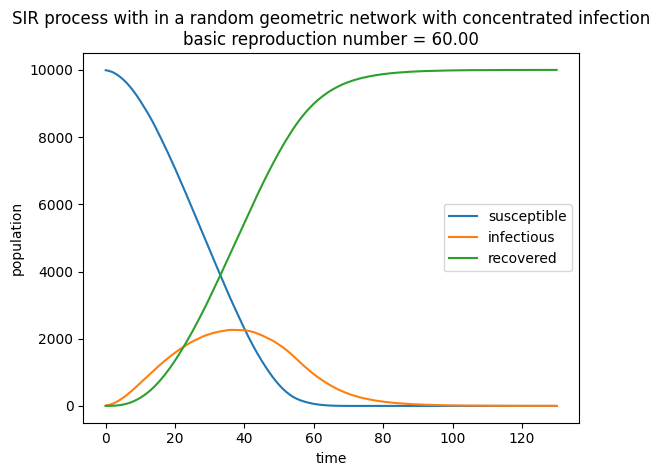

In [291]:
time = np.arange(0, len(Sc), 1)
plt.plot(time, Sc, label="susceptible")
plt.plot(time, Ic, label="infectious")
plt.plot(time, Rc, label="recovered")
plt.legend()
plt.title(f"SIR process with in a random geometric network with concentrated infection" +
          f"\nbasic reproduction number = {find_basic_reproduction_number(infection_probability, recovery_probability):.2f}")
plt.xlabel("time")
plt.ylabel("population")
plt.show()

In [292]:
# Averaged sample
Sc_2, Ic_2, Rc_2 = np.zeros(max_size), np.zeros(max_size), np.zeros(max_size)
avg_idx_c2 = 0
for _ in range(sample_size):
    rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})
    concentrated_rgg = Infectious_Network(rgg, infection_probability_small, recovery_probability, initial_infection, True)
    S, I, R = concentrated_rgg.increment_till_extinction()
    avg_idx_c2 += len(S)
    Sc_2 += append_till_length(S)
    Ic_2 += append_till_length(I)
    Rc_2 += append_till_length(R)

Sc_2 /= sample_size
Ic_2 /= sample_size
Rc_2 /= sample_size  
avg_idx_c2 /= sample_size 
avg_idx_c2 = int(avg_idx_c2)

Sc_2, Ic_2, Rc_2 = Sc_2[:avg_idx_c2], Ic_2[:avg_idx_c2], Rc_2[:avg_idx_c2]

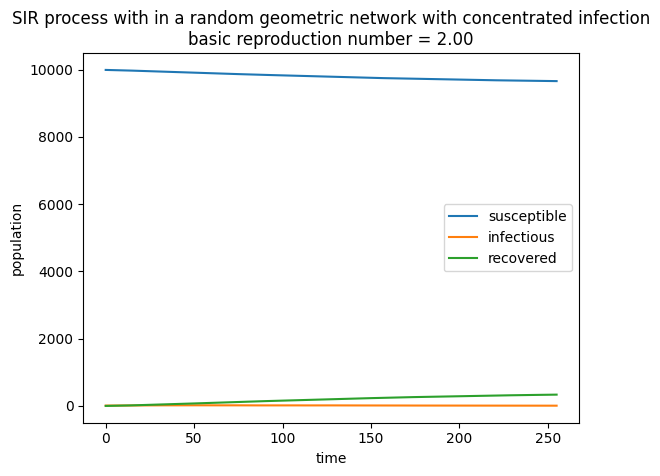

In [293]:
time = np.arange(0, len(Sc_2), 1)
plt.plot(time, Sc_2, label="susceptible")
plt.plot(time, Ic_2, label="infectious")
plt.plot(time, Rc_2, label="recovered")
plt.legend()
plt.title(f"SIR process with in a random geometric network with concentrated infection" +
          f"\nbasic reproduction number = {find_basic_reproduction_number(infection_probability_small, recovery_probability):.2f}")
plt.xlabel("time")
plt.ylabel("population")
plt.show()

Final infection population

In [ ]:
basic_reproduction_number_array = np.arange(0.8, 4.8, 0.2)
sample_size = 10

outbreak_size_c = np.zeros((sample_size, len(basic_reproduction_number_array)))
outbreak_extinction_time_c = np.zeros((sample_size, len(basic_reproduction_number_array)))

outbreak_size_d = np.zeros((sample_size, len(basic_reproduction_number_array)))
outbreak_extinction_time_d = np.zeros((sample_size, len(basic_reproduction_number_array)))

In [ ]:
for sample_num in range(sample_size):
    for concentrated in [False, True]:
        for r_num, basic_reproduction_number in enumerate(basic_reproduction_number_array):
            print(sample_num, basic_reproduction_number)
            infection_probability_brn = basic_reproduction_number * recovery_probability / k_avg
            rgg = nx.random_geometric_graph(num_nodes, radius, pos={i: nodes_positions[i] for i in range(num_nodes)})
            infectious_rgg = Infectious_Network(rgg, infection_probability_brn, recovery_probability, initial_infection, concentrated)
            S, I, R = infectious_rgg.increment_till_extinction()
            if concentrated:
                outbreak_size_c[sample_num][r_num] = R[-1]
                outbreak_extinction_time_c[sample_num][r_num] = len(R)
            else: 
                outbreak_size_d[sample_num][r_num] = R[-1]
                outbreak_extinction_time_d[sample_num][r_num] = len(R)


average_outbreak_size_c = np.mean(outbreak_size_c, axis=0)
average_outbreak_size_d = np.mean(outbreak_size_d, axis=0)

var_outbreak_size_c = np.var(outbreak_size_c, axis=0)
var_outbreak_size_d = np.var(outbreak_size_d, axis=0)

In [306]:
print(outbreak_size_c)
print(outbreak_size_d)

[[  21.   29.   33.   21.  162.  284.  805. 1351.   64. 3092. 8126. 8804.
  8750. 8797. 9103. 9262. 9440. 9540. 9495. 9653.]
 [  11.   28.   29.   64.  109.  285.  276.  228.  418. 7621. 7891. 8570.
  8662. 8974. 9158. 9311. 9471. 9550. 9566. 9625.]
 [  11.   20.   18.   29.   22.  153.  363. 1623. 4648.  690. 7958. 8414.
  8240. 8953. 9235. 9358. 9378. 9524. 9506. 9639.]
 [  22.   92.   17.   17.   18.   57.   98. 1309. 1467. 6027. 7379. 8608.
  8675. 9046. 9092. 9255. 9419. 9547. 9590. 9614.]
 [  12.   21.   10.  103.   21.  308.  512.  625.  306. 5424. 7823. 8536.
  8908. 8832. 9268. 9426. 9404. 9533. 9556. 9660.]
 [  23.   16.   21.  124.   93.   66.  778.   12.  438. 7056. 7647. 8386.
  8822. 9137. 9163. 9258. 9420. 9474. 9570. 9618.]
 [  20.   12.   15.  112.   22.   60.   56.  351. 6467.   12. 7596. 8371.
  8823. 9043. 9241. 9369. 9420. 9532. 9581. 9677.]
 [  14.   10.   23.   23.   27.  165.  219. 2415. 2190. 7134. 7977. 8570.
  8822. 8943. 9105. 9291. 9442. 9504. 9624. 9654.]


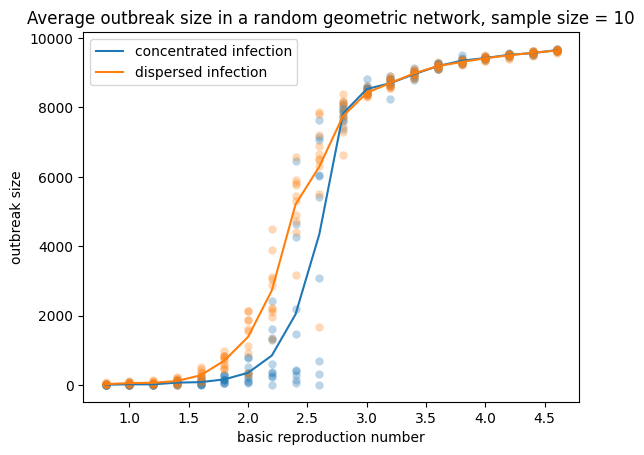

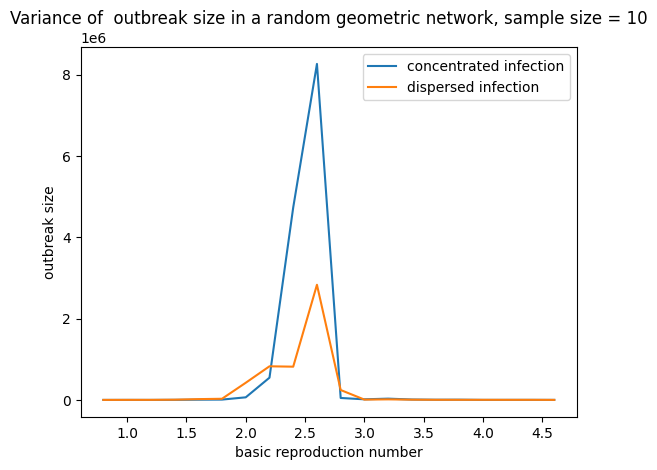

In [305]:
for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, outbreak_size_c[sample_num], lw = 0, alpha = 0.3, color="#1f77b4")
plt.plot(basic_reproduction_number_array, average_outbreak_size_c, label="concentrated infection", color="#1f77b4")

for sample_num in range(sample_size):
    plt.scatter(basic_reproduction_number_array, outbreak_size_d[sample_num], lw = 0, alpha = 0.3, color="#ff7f0e")
plt.plot(basic_reproduction_number_array, average_outbreak_size_d, label="dispersed infection", color="#ff7f0e")
plt.legend()
plt.title(f"Average outbreak size in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("outbreak size")
plt.show()

plt.plot(basic_reproduction_number_array, var_outbreak_size_c, label="concentrated infection")
plt.plot(basic_reproduction_number_array, var_outbreak_size_d, label="dispersed infection")
plt.legend()
plt.title(f"Variance of  outbreak size in a random geometric network, sample size = {sample_size}")
plt.xlabel("basic reproduction number")
plt.ylabel("outbreak size")
plt.show()